In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler, BorderlineSMOTE, SMOTE, ADASYN
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.stats import boxcox
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from factor_analyzer import calculate_kmo
from factor_analyzer import FactorAnalyzer

In [2]:
import matplotlib.font_manager as fm
import matplotlib

font_location = 'C:/Windows/Fonts/malgun.ttf' # 폰트 파일 이름, 디렉토리 주의
font_name = fm.FontProperties(fname = font_location).get_name()
matplotlib.rc('font', family=font_name)
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정(필수)

# 현재 글꼴 확인
print(plt.rcParams['font.family'])

['Malgun Gothic']


In [3]:
지역_df = pd.read_csv('마스터_지역별식중독_A04_찐막.csv').sort_values(by = ['OCCRNC_AREA','OCCRNC_YEAR','OCCRNC_MM']).reset_index(drop = True)

### 1. 데이터 전처리

In [5]:
지역_df_portion = 지역_df.copy()

지역_df_portion['초등학생인구비율'] = 지역_df_portion['초등학생인구'] / 지역_df_portion['인구']
지역_df_portion['중학생인구비율'] = 지역_df_portion['중학생인구'] / 지역_df_portion['인구']
지역_df_portion['고등학생인구비율'] = 지역_df_portion['고등학생인구'] / 지역_df_portion['인구']
지역_df_portion['60세이상인구비율'] = 지역_df_portion['60세이상인구수'] / 지역_df_portion['인구']

지역_df_portion.insert(loc = 4, column = '환자수발생비율', value = 지역_df_portion['PATNT_CNT'] / 지역_df_portion['인구'])
지역_df_portion.insert(loc = 4, column = 'PATNT_CNT_3Q', value = pd.qcut(지역_df_portion.loc[지역_df_portion['PATNT_CNT'] != 0, 'PATNT_CNT'], q = [0, 0.33, 0.66, 1]))

지역_df_portion['PATNT_CNT_3Q'] = 지역_df_portion['PATNT_CNT_3Q'].replace(지역_df_portion['PATNT_CNT_3Q'].unique(), [0, 1,np.nan, 2])

지역_df_portion = 지역_df_portion.drop(columns = ['인구','초등학생인구','중학생인구','고등학생인구','60세이상인구수','인구밀도'])

C:\Users\user\AppData\Local\Temp\ipykernel_5552\3997789300.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  지역_df_portion['PATNT_CNT_3Q'] = 지역_df_portion['PATNT_CNT_3Q'].replace(지역_df_portion['PATNT_CNT_3Q'].unique(), [0, 1,np.nan, 2])
C:\Users\user\AppData\Local\Temp\ipykernel_5552\3997789300.py:11: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  지역_df_portion['PATNT_CNT_3Q'] = 지역_df_portion['PATNT_CNT_3Q'].replace(지역_df_portion['PATNT_CNT_3Q'].unique(), [0, 1,np.nan, 2])


- OverSampling

In [198]:
over_sampler = RandomOverSampler(sampling_strategy='minority')
X_train_over, y_train_over = over_sampler.fit_resample(X_train_sc, y_train)

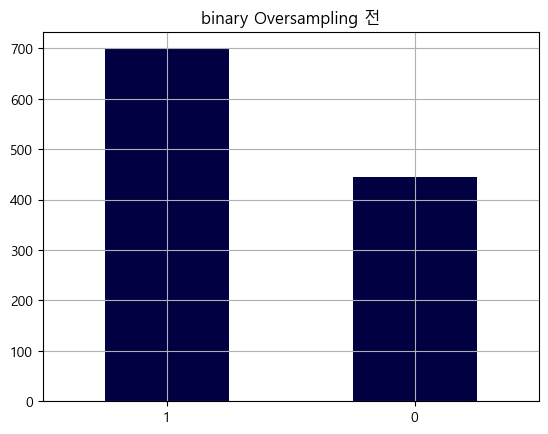

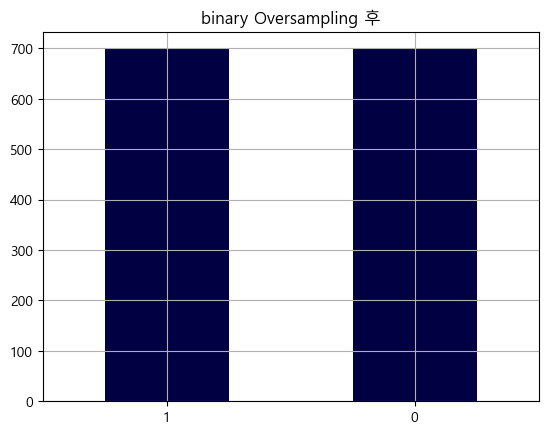

In [428]:
y_train.value_counts().plot(kind = 'bar',rot = 0, color = '#000043')
plt.xlabel('')
plt.title('binary Oversampling 전')
plt.grid()
# plt.title('식중독 발생여부_Oversampling 전')
plt.show()

y_train_over.value_counts().plot(kind = 'bar',rot = 0, color = '#000043')
plt.xlabel('')
plt.title('binary Oversampling 후')
plt.grid()
# plt.title('식중독 발생여부_Oversampling 후')
plt.show()

In [219]:
# 초/중/고등학생/60세이상인구비율 제외
X1 = 지역_df_portion.drop(columns = ['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_AREA', 'PATNT_CNT', 'PATNT_CNT_3Q','환자수발생비율', 'OCCRNC_CNT', 'binary', '초등학생인구비율', '중학생인구비율','고등학생인구비율','60세이상인구비율'])

# 초/중/고등학생/60세이상인구비율 포함
X2 = 지역_df_portion.drop(columns = ['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_AREA', 'PATNT_CNT', 'PATNT_CNT_3Q','환자수발생비율', 'OCCRNC_CNT', 'binary'])

# 집단급식소인허가수 제외
X3 = 지역_df_portion.drop(columns = ['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_AREA', 'PATNT_CNT', 'PATNT_CNT_3Q','환자수발생비율', 'OCCRNC_CNT', 'binary','집단급식소인허가수'])

# COVID 관련 변수 제외
X4 = 지역_df_portion.drop(columns = ['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_AREA', 'PATNT_CNT', 'PATNT_CNT_3Q','환자수발생비율', 'OCCRNC_CNT', 'binary','COVID_PERIOD', 'COVID_Confirmed', 'COVID_Deaths', 'COVID_Fatality_Rate', 'COVID_Cumulative_Fatality_Rate', 'COVID_National_Fatality_Rate'])

# COVID 관련 변수 + 집단급식소인허가수 제외
X5 = 지역_df_portion.drop(columns = ['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_AREA', 'PATNT_CNT', 'PATNT_CNT_3Q','환자수발생비율', 'OCCRNC_CNT', 'binary','COVID_PERIOD', 'COVID_Confirmed', 'COVID_Deaths', 'COVID_Fatality_Rate', 'COVID_Cumulative_Fatality_Rate', 'COVID_National_Fatality_Rate','집단급식소인허가수'])

y1 = 지역_df_portion.binary
y2 = 지역_df_portion.PATNT_CNT_3Q.dropna()

### 2. 모델링

In [221]:
def clf_modeling(X, y, model, model_param):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    mm_scaler = MinMaxScaler()
    X_train_sc = mm_scaler.fit_transform(X_train)
    X_test_sc = mm_scaler.transform(X_test)
    over_sampler = RandomOverSampler(random_state=42, sampling_strategy='minority')
    X_train_over, y_train_over = over_sampler.fit_resample(X_train_sc, y_train)
    clf_grid = GridSearchCV(estimator=model, param_grid = model_param, scoring = 'accuracy')
    clf_grid.fit(X_train_over, y_train_over)
    y_pred = clf_grid.predict(X_test_sc)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    feature_imp_dict = {feature : imp for feature, imp in zip(X.columns, clf_grid.best_estimator_.feature_importances_)}
    print(f''''validation best_score = {clf_grid.best_score_:.4f}, test data best_score = {test_accuracy:.4f}, best_parameter : {clf_grid.best_params_}''')
    print(f''' Top 3 features : {sorted(feature_imp_dict.items(), key = lambda x : x[1], reverse = True)[:3]}''')
    print(f''' Bottom 3 features : {sorted(feature_imp_dict.items(), key = lambda x : x[1])[:3]}
    ''')
    
    return clf_grid

In [239]:
def svc_modeling(X, y, model, model_param):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    mm_scaler = MinMaxScaler()
    X_train_sc = mm_scaler.fit_transform(X_train)
    X_test_sc = mm_scaler.transform(X_test)
    over_sampler = RandomOverSampler(sampling_strategy='minority')
    X_train_over, y_train_over = over_sampler.fit_resample(X_train_sc, y_train)
    clf_grid = GridSearchCV(estimator=model, param_grid = model_param, scoring = 'accuracy')
    clf_grid.fit(X_train_over, y_train_over)

    y_pred = clf_grid.predict(X_test_sc)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    print(f''''validation best_score = {clf_grid.best_score_:.4f}, test data best_score = {test_accuracy:.4f}, best_parameter : {clf_grid.best_params_}''')
    
    return clf_grid

- 랜덤포레스트 분류모형

In [228]:
rf_clf_model = RandomForestClassifier(random_state = 42)

In [230]:
rf_clf_model.fit(X_train_over, y_train_over)

rf_clf_model.score(X_test_sc, y_test)

0.7489795918367347

In [226]:
rf_clf_y1_X2 = clf_modeling(X2, y1, RandomForestClassifier(random_state = 42), {'n_estimators' :[100, 150, 200], 'max_depth':[None, 10, 20], 'min_samples_split':[2, 3]})

'validation best_score = 0.8045, test data best_score = 0.7837, best_parameter : {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
 Top 3 features : [('집단급식소인허가수', 0.08213888485451362), ('초등학생인구비율', 0.059108167117867885), ('중학생인구비율', 0.05240400368525202)]
 Bottom 3 features : [('IS_GOLDEN_HOLIDAY', 0.0035639665679977972), ('COVID_PERIOD', 0.0036560309511619697), ('Festival Exists', 0.004098124860891026)]
    


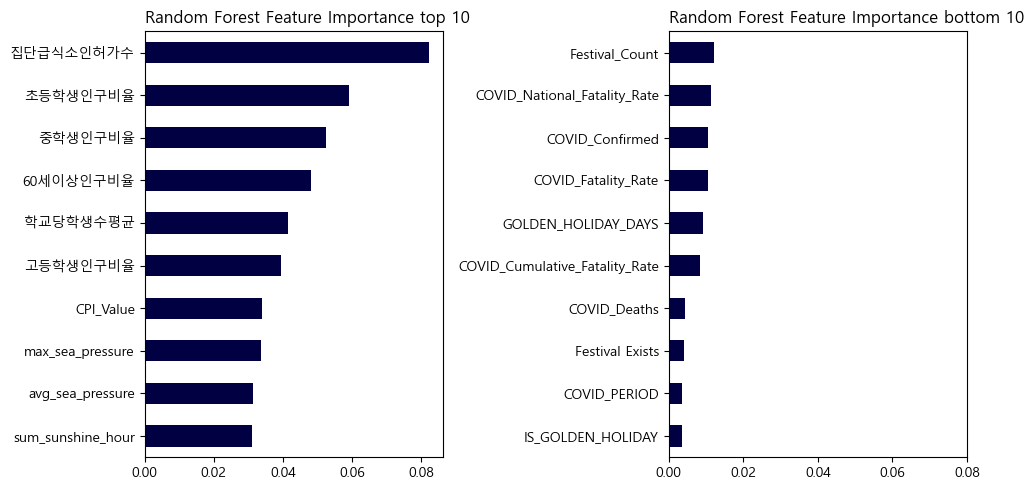

In [515]:
plt.figure(figsize = (10, 5))
plt.subplot(121)
pd.Series(rf_clf_y1_X2.best_estimator_.feature_importances_, index = X2.columns).sort_values(ascending = False)[:10]\
.sort_values().plot(kind = 'barh', color = '#000043')
plt.title('Random Forest Feature Importance top 10', loc = 'left')
plt.subplot(122)
pd.Series(rf_clf_y1_X2.best_estimator_.feature_importances_, index = X2.columns).sort_values(ascending = False)[-10:]\
.sort_values().plot(kind = 'barh', color = '#000043')
plt.xlim([0,0.08])
plt.title('Random Forest Feature Importance bottom 10', loc = 'left')
plt.tight_layout()
plt.show()

- XGBoost 분류모델

In [202]:
xgb_clf_model = XGBClassifier(random_state = 42)

In [213]:
xgb_clf_model.fit(X_train_over, y_train_over)

xgb_clf_model.score(X_test_sc, y_test)

0.7224489795918367

In [223]:
clf_modeling(X2, y1, XGBClassifier(random_state = 42), {'n_estimators' :[100, 150, 200], 'grow_policy':['depthwise','lossguide'], 'max_depth':[None, 10, 20]})

'validation best_score = 0.7909, test data best_score = 0.7367, best_parameter : {'grow_policy': 'depthwise', 'max_depth': 10, 'n_estimators': 100}
 Top 3 features : [('집단급식소인허가수', 0.075725466), ('COVID_National_Fatality_Rate', 0.0683277), ('COVID_Fatality_Rate', 0.06487572)]
 Bottom 3 features : [('Festival Exists', 0.0), ('avg_precip_boxcox', 0.0), ('avg_windspeed_boxcox', 0.0)]
    


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'grow_policy': ['depthwise', 'lossguide'],
                         'max_depth': [None, 10, 20],
                         'n_estimators': [100, 150, 200]},
             scoring='accuracy')

- 로지스틱회귀

In [248]:
logistic_model = LogisticRegression(random_state=42)

In [250]:
logistic_model.fit(X_train_over, y_train_over)

logistic_model.score(X_test_sc, y_test)

0.6795918367346939

In [252]:
svc_modeling(X2, y1, LogisticRegression(random_state=42), {'max_iter':[100,200], 'C':[1.0, 0.5], 'solver':['lbfgs', 'liblinear', 'newton-cg']})

'validation best_score = 0.6948, test data best_score = 0.7184, best_parameter : {'C': 1.0, 'max_iter': 100, 'solver': 'liblinear'}


GridSearchCV(estimator=LogisticRegression(random_state=42),
             param_grid={'C': [1.0, 0.5], 'max_iter': [100, 200],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg']},
             scoring='accuracy')

- 서포트벡터머신

In [243]:
svc_model =  SVC(random_state=42)
svc_model.fit(X_train_over, y_train_over)

svc_model.score(X_test_sc, y_test)

0.689795918367347

In [241]:
svc_y1_X2 = svc_modeling(X2, y1, SVC(random_state=42), {'degree':[2,3], 'C':[1.0, 0.5]})

'validation best_score = 0.6934, test data best_score = 0.7143, best_parameter : {'C': 1.0, 'degree': 2}
